In [1]:
# Load my Packages
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
# Assign hidden API key
with open("api_stuff.txt", "r") as file:
    api_key = file.read()

In [3]:
# Tables that are ready
players_df = pd.read_csv('data/players.csv') # 393 players
ts_df = pd.read_csv('data/teams.csv') # 30 teams
stats = pd.read_csv('data/stats.csv')
final_df = pd.read_csv('data/final_table.csv')

In [28]:
# Extract Teams info from API
urlt = "https://api-nba-v1.p.rapidapi.com/teams"

headers = {
	"X-RapidAPI-Key": api_key,
	"X-RapidAPI-Host": "api-nba-v1.p.rapidapi.com"
}

teams = requests.get(urlt, headers=headers)
t_df = pd.DataFrame(teams.json()['response'])

# Select only the ones in the nba Franchise
t_df = t_df[t_df['nbaFranchise'] == True]

#t_df.to_csv('teams.csv', index=False)
# We have 31 teams 


In [55]:
# Should we skip team 37 (#id 27)
# Get players info from API
urlp = "https://api-nba-v1.p.rapidapi.com/players"

# # # Create empty dataframe when initializing players_df tabble
# columns = ['id', 'firstname', 'lastname', 'birth_date', 'height_m', 'weight_kg']
# players_df = pd.DataFrame(columns=columns) 

# For each team get the players info (We have 31 teams, we will do 10 by 10)
for i in range(0,31): # Up to the index 31 (# Skip team 37 (#id 27))
	print('team', t_df.iloc[i]['id'])
	querystring = {"team": t_df.iloc[i]['id'], "season": "2023"}

	headers = {
		"X-RapidAPI-Key": api_key,
		"X-RapidAPI-Host": "api-nba-v1.p.rapidapi.com"
	}

	players = requests.get(urlp, headers=headers, params=querystring)

	p_df = pd.DataFrame(players.json()['response'])
	
	### Clean Players Data
	# Add Birth date column
	p_df['birth_date'] = p_df['birth'].apply(lambda x: pd.to_datetime(x['date']) if x['date'] else None)

	# Add height in meters column
	p_df['height_m'] = p_df['height'].apply(lambda x: float(x['meters']) if x['meters'] else None)

	# Add weight in kilograms column
	p_df['weight_kg'] = p_df['weight'].apply(lambda x: float(x['kilograms']) if x['kilograms'] else None)

	# Remove unnecessary columns
	p_df = p_df[['id', 'firstname', 'lastname', 'birth_date', 'height_m', 'weight_kg']]

	# Remove players with NAs
	p_df = p_df.dropna()

	# Create Age column
	p_df['age'] = (datetime.now() - p_df['birth_date']).astype('<m8[Y]').astype(int)

	# add each player info season and team to my players df
	players_df = pd.concat([players_df, p_df], ignore_index=True)

# Order by Player ID
players_df = players_df.sort_values('id')

# Write into a csv File
# players_df.to_csv('data/players.csv', index=False) 
# # We have 393 players


team 24
team 25
team 26
team 27
team 28
team 29
team 30
team 31


In [57]:
# Get Player stats per game info from API
urlps = "https://api-nba-v1.p.rapidapi.com/players/statistics"
ps = pd.DataFrame()
for i in range(160,170): # I have 393 players (do 10 by 10)
	querystring = {"id":players_df.iloc[i]['id'],"season":"2023"}

	headers = {
		"X-RapidAPI-Key": api_key,
		"X-RapidAPI-Host": "api-nba-v1.p.rapidapi.com"
	}

	player_ps = requests.get(urlps, headers=headers, params=querystring)
	ps = pd.concat([ps, pd.DataFrame(player_ps.json()['response'])], ignore_index=True)


In [58]:
# Clean stats table

# Add player id
ps['id'] = ps['player'].apply(lambda x: x['id'] if x['id'] else None)

# Add player name
ps['name'] = ps['player'].apply(lambda x: x['firstname'] + " "  + x['lastname'])

# Add team code
ps['team'] = ps['team'].apply(lambda x: x['code'] if x['code'] else None)

# Edit plusMinus to be a number
ps['plusMinus'] = ps['plusMinus'].apply(lambda x: int(x[1:]) * -1 if x and x[0] == '-' else int(x) if x != '' else None)

# Edit min to be a number
ps['min'] = ps['min'].apply(lambda x: int(x) if str(x).isnumeric() else None)

# Make them numeric otherwise null for percentage columns
ps['fgp'] = pd.to_numeric(ps['fgp'], errors='coerce')
ps['ftp'] = pd.to_numeric(ps['ftp'], errors='coerce')
ps['tpp'] = pd.to_numeric(ps['tpp'], errors='coerce')

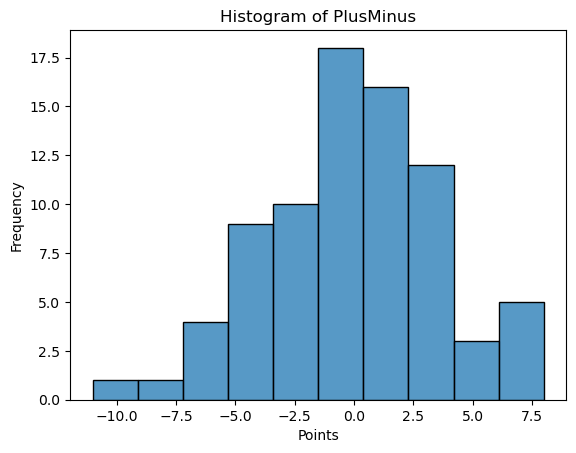

In [ ]:
# PlusMinus Histogram

# Heigth Histogram
sns.histplot(stats['plusMinus'])

# Optional: Customize plot labels and title
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.title('Histogram of PlusMinus')

# Show the plot
plt.show()

In [59]:
# Group by player
ps = ps.groupby('id').agg({
    'name': 'first',
    'team': 'first',
    'pos': 'first',
    'game': 'count',
    'points': 'mean',
    'min' : 'mean', 
    'fgm' : 'mean', 
    'fga': 'mean', 
    'fgp': 'mean',
    'ftm' : 'mean', 
    'fta': 'mean', 
    'ftp': 'mean', 
    'tpm': 'mean', 
    'tpa': 'mean', 
    'tpp': 'mean', 
    'offReb': 'mean', 
    'defReb': 'mean', 
    'totReb': 'mean',
    'assists': 'mean', 
    'pFouls': 'mean', 
    'steals': 'mean', 
    'turnovers': 'mean', 
    'blocks': 'mean',
    'plusMinus': 'mean'
}).reset_index().round()

# Make all numeric variables integers
ps.iloc[:, 4:] = ps.iloc[:, 4:].astype(int)

# Add performance column
ps['performance'] = pd.cut(ps['plusMinus'], bins=[-float('inf'), -3, 3, float('inf')], labels=['low', 'average', 'high'])

# Turn percentages to decimals
ps['fgp'] = ps['fgp'] / 100
ps['ftp'] = ps['ftp'] / 100
ps['tpp'] = ps['tpp'] / 100

# Start over
# stats = pd.DataFrame()

# Add to our existing table
stats = pd.concat([stats, ps], ignore_index=True)

/var/folders/3g/j5vh3c7n53sb924vl6sb5jbc0000gn/T/ipykernel_1055/1855402143.py:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ps.iloc[:, 4:] = ps.iloc[:, 4:].astype(int)


In [7]:
# Create a t score formula 
def get_t(x, column):
    t = (x - column.mean()) / column.std()
    return t


In [8]:
# Create function to get greatest strength for a given player, comparing t_scores between skills
def get_b_strength(player):
    skills = ['fgp', 'ftp', 'tpp', 'totReb', 'assists', 'steals']
    max = -3
    m_skill = "None"
    for i in skills:
        t_score = get_t(player[i], stats[i])
        if t_score > max:
            max = t_score
            m_skill = i
    if max <= 0:
        if player['blocks'] == 1:
            m_skill == 'blocks'
    return m_skill
    

In [9]:
# Create function to get worst weekednes for a given player (row)
def get_b_weakness(player):
    w = ['turnovers', 'pFouls']
    max = -3
    m_skill = "None"
    for i in w:
        t_score = get_t(player[i], stats[i])
        if t_score > max:
            max= t_score
            m_skill = i
    if max <= 0:
        min = 3
        skills = ['fgp', 'ftp', 'tpp', 'totReb', 'assists']
        for i in skills:
            t_score = get_t(player[i], stats[i])
            if t_score < min:
                min = t_score
                m_skill = i
        if min >= 0:
            if player['blocks'] != 1:
                m_skill == 'blocks'
    return m_skill

In [60]:
# Create b_strength column
stats['b_strength'] = [get_b_strength(stats.iloc[i]) for i in range(len(stats))]

In [61]:
# Create b_weakedness column
stats['b_weakness'] = [get_b_weakness(stats.iloc[i]) for i in range(len(stats))]

In [62]:
# Write the table in a CSV file
stats.to_csv('data/stats.csv', index=False)

In [63]:
# Add my players info with their stats
final_df = pd.merge(stats, players_df[['id', 'height_m', 'weight_kg', 'age']])


In [81]:
# Write final csv file
final_df.to_csv('data/final_table.csv', index=False)

In [65]:
len(final_df)

104

**EDA Exploratory Data Analsysis**

_Question to Answer_

I started:
- Distribution of each number type (Understand data and start asking questions)
- Collinearity between skills (Heat map) - Do I have renundancy in my stats?
- Relationship between Height and Weight (Do we need both, or does one pretty much tells the other one) - I say yes

Height Questions

- Distribution of Height per position (Does height influence which position you will have?) I say yes
- Distribution of Height per strength (Does strength influence which position you will have?) I say yes
- Distribution of Height per Weakness (Does weakness influence which position you will have?) I say no
- Distribution of Height per Perfomance (Does height determine your perfomance?) I say no
- Relationship between Height and plusMinus (Does height determine your perfomance?) I say no
- Relationship between Height and Blocks (Does height influence your blocks ability?) I say yes
- Relationship between Height and Points (Do you score more points if you are taller?)
- Relationship between skills and Height (Linear Regression)
- Which range of Weight should you have if you have a given height (Predictive question)

Position Question
- Count for Positions
- Certains positions score more?
- Relationship between position and strength (Based on your position, which is your most likely strength)
- Relationship between position and weakness (Based on your position, which is your most likely strength)
- Relationship between position and skills (Based on your position, which is your top 3 skills you should focus on)
- Relationship between position and Performance (Does position determines your perfomance?)
- Relationship between position and plusMinus (Does position determines your perfomance?)
- Relationship between mins and position (How much time will I play for a given position)

Final Question
- Based on Heigth and desired position, what skills should I have to be high performing player?

In [ ]:
# Realized there are a tone of questions I can asnwer, but I'll focus on those topics

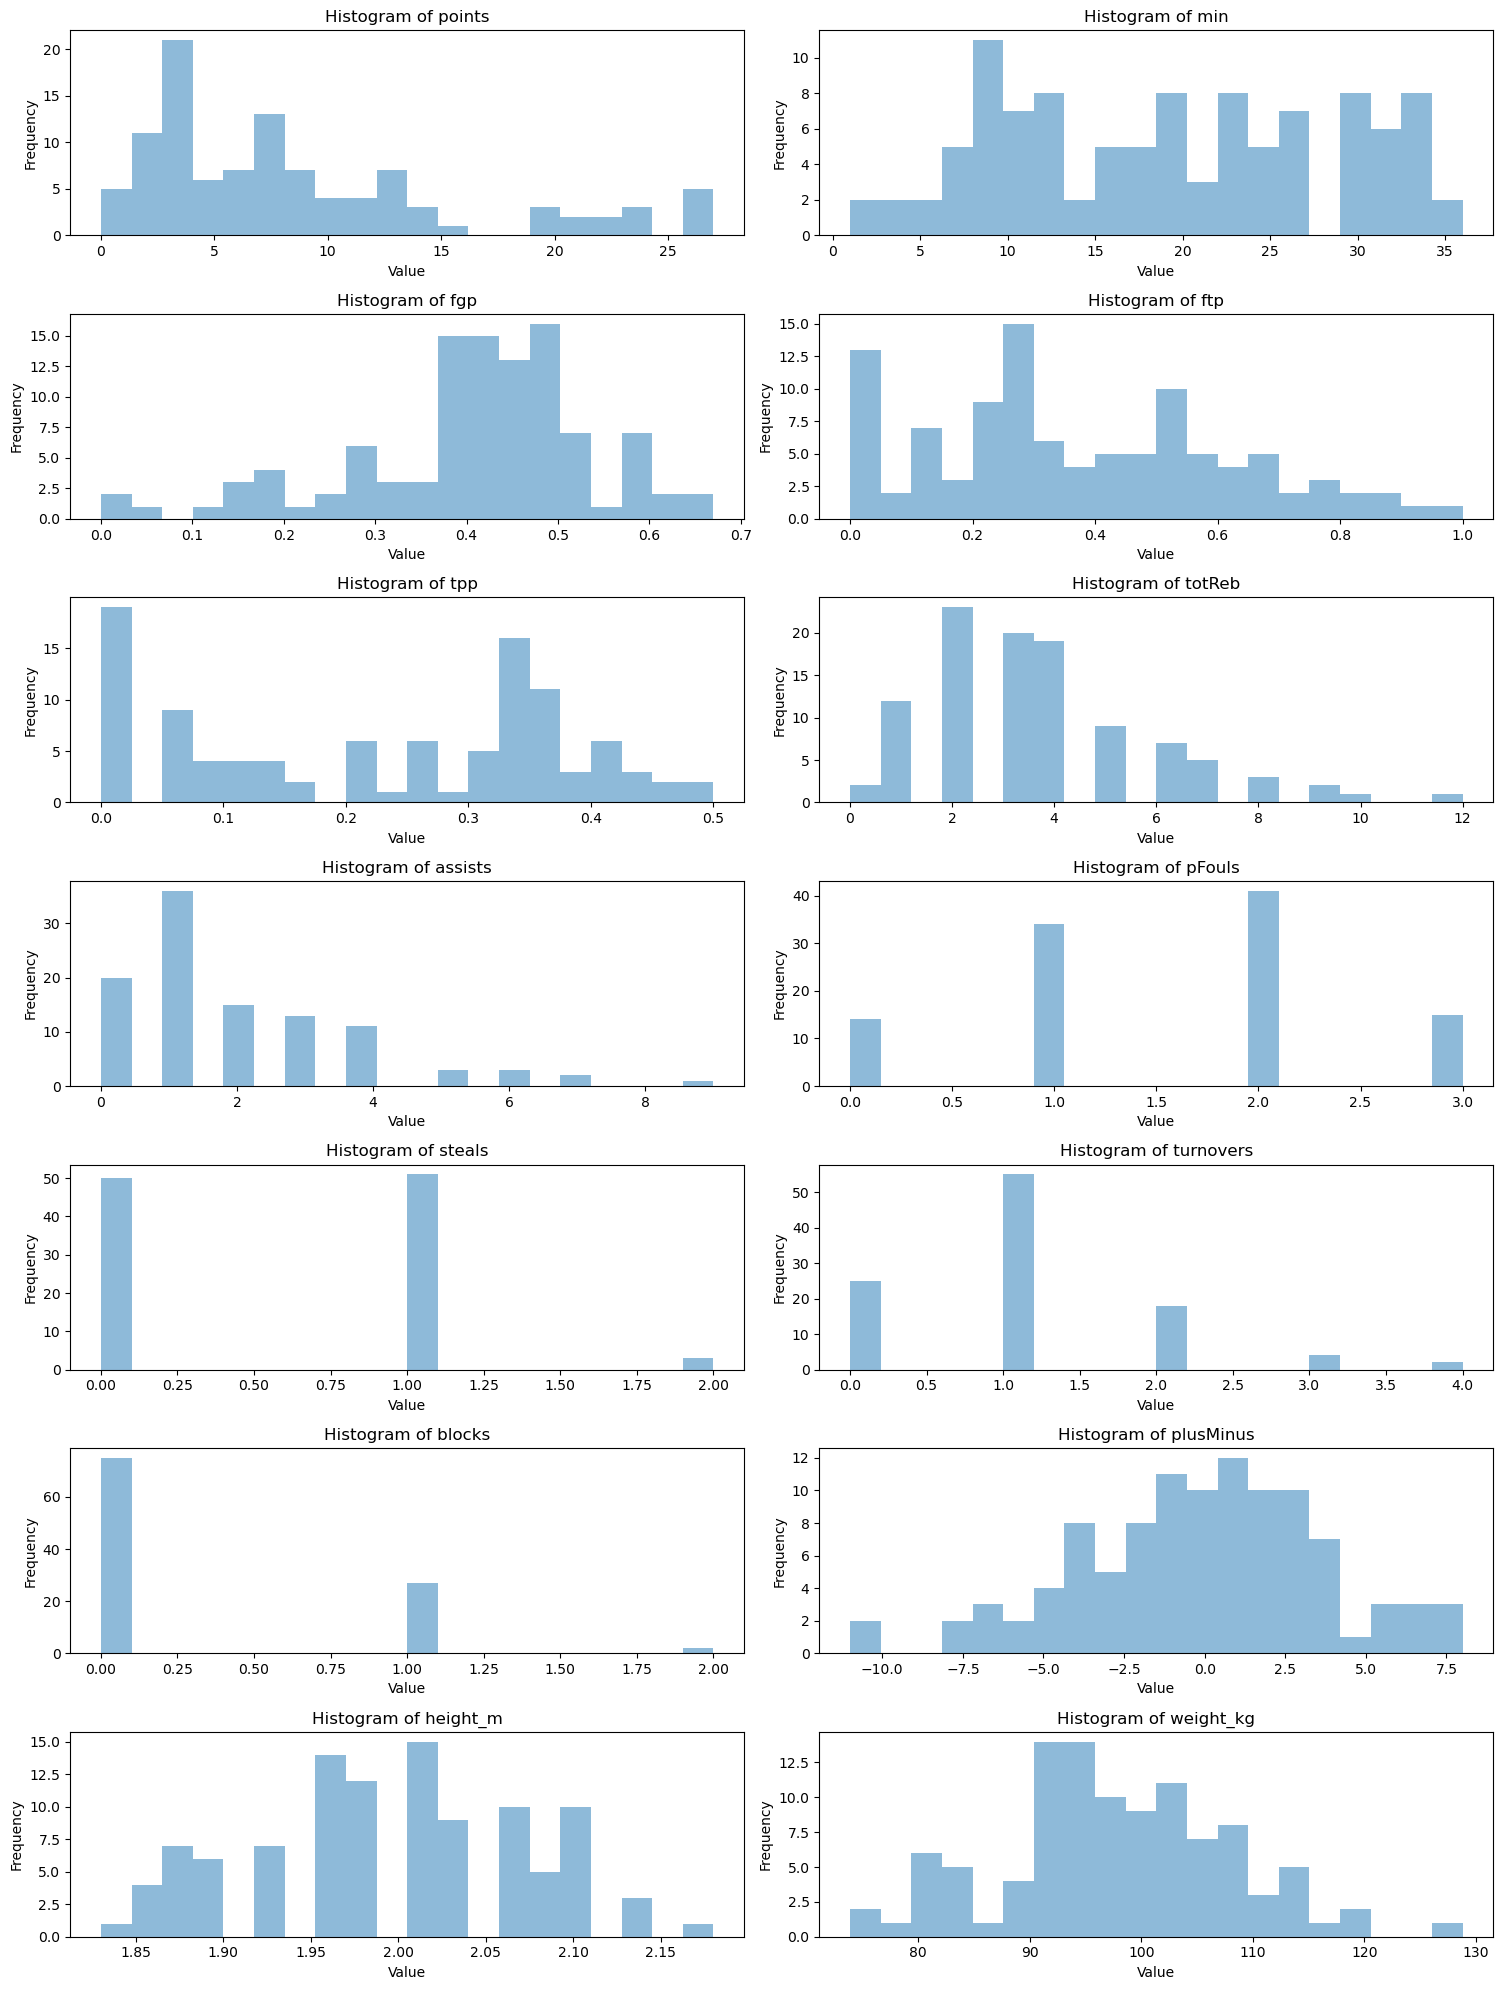

In [66]:
# Distribution of each Skill

selected_columns = ['points', 'min','fgp','ftp', 'tpp', 'totReb', 'assists', 'pFouls', 'steals',
       'turnovers', 'blocks', 'plusMinus', 'height_m', 'weight_kg']

# Creating subplots
fig, axes = plt.subplots(nrows=len(selected_columns)//2, ncols=2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

# Plotting histograms for each selected column in separate subplots
for col, ax in zip(selected_columns, axes.flatten()):
    ax.hist(final_df[col], bins=20, alpha=0.5)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

In [ ]:
# I thought this graph would be usefull but it only raised more questions in my mind. So I'll focus with the questions I already wrote for now.

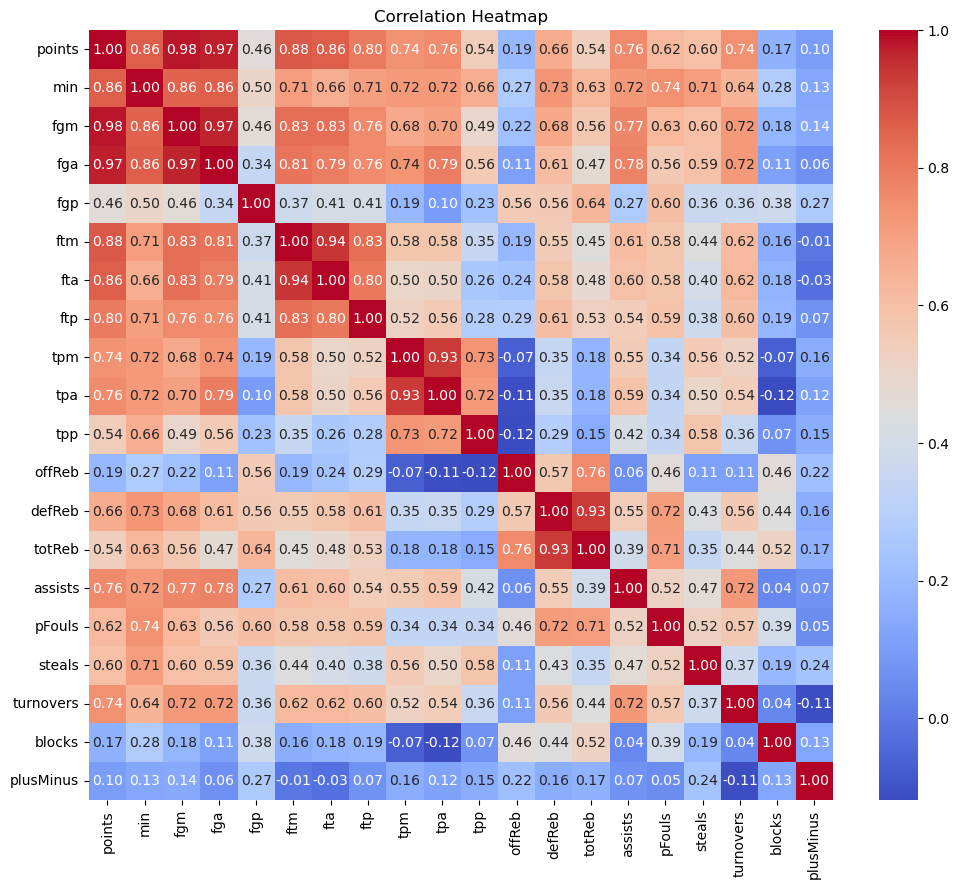

In [28]:
# Collinearity between variables of interest

# Replace it with your actual data
correlation_matrix = final_df.iloc[:,5:25].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Add a title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

### FIX SIZE

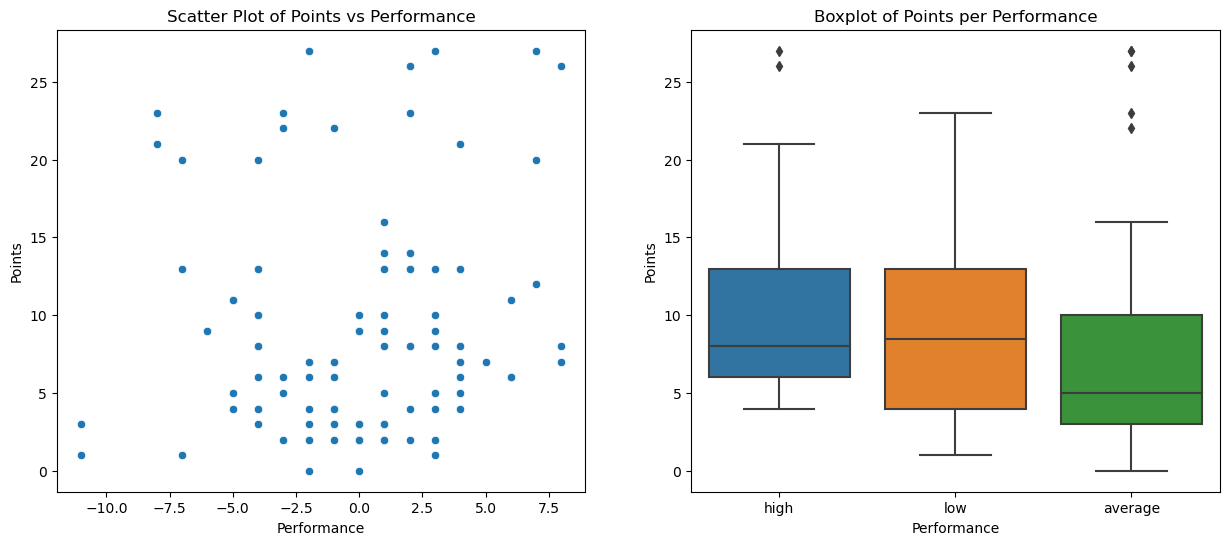

In [67]:
# Relationship between Performance and Points
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

# Create a scatter plot
sns.scatterplot(x='plusMinus', y='points', data=final_df, ax=ax1)

# Add labels and title
ax1.set_xlabel("Performance")
ax1.set_ylabel("Points")
ax1.set_title(f'Scatter Plot of Points vs Performance')

# Relationship between Points and Performance
sns.boxplot(data = final_df, x = 'performance', y='points',  dodge=True, ax=ax2)
ax2.set_xlabel('Performance')
ax2.set_ylabel('Points')
ax2.set_title('Boxplot of Points per Performance')

# Save the plot to the specified file path
plt.savefig('../my-blog/assets/images/pointsVSperf.png')

# Show the plot
plt.show()


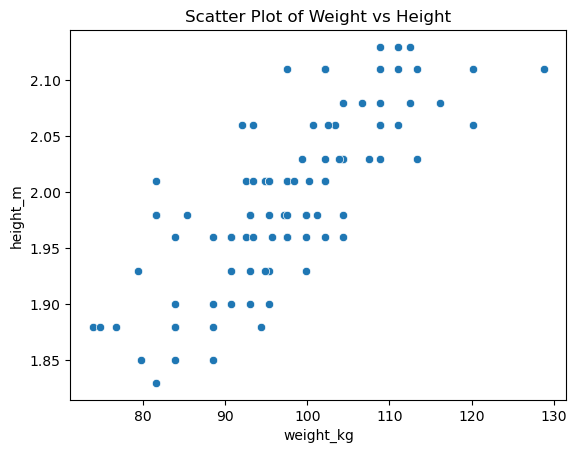

In [42]:
# Rlationship between Weight and Height

col1 = 'weight_kg'
col2 = 'height_m'

# Create a scatter plot
sns.scatterplot(x=col1, y=col2, data=final_df)

# Add labels and title
plt.xlabel(col1)
plt.ylabel(col2)
plt.title(f'Scatter Plot of Weight vs Height')

# Save the plot to the specified file path
plt.savefig('../my-blog/assets/images/weightVSheight.png')

plt.show()


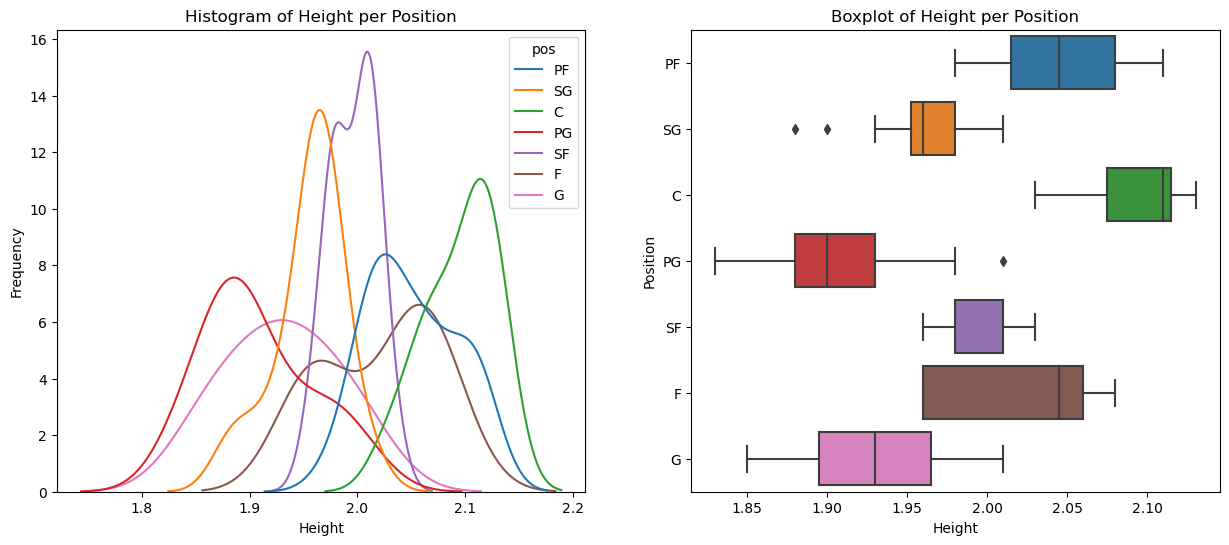

In [43]:
# Heigth per position

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

#Density curve
sns.kdeplot(data = final_df, x = 'height_m', hue='pos', ax=ax1, common_norm=False)
ax1.set_xlabel('Height')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Height per Position')

# Box plot
sns.boxplot(data = final_df, x = 'height_m', y='pos',  dodge=True, ax=ax2)
ax2.set_xlabel('Height')
ax2.set_ylabel('Position')
ax2.set_title('Boxplot of Height per Position')

# Save the plot to the specified file path
plt.savefig('../my-blog/assets/images/heightPRposition.png')

# Show the plot
plt.show()

In [39]:
print(f"Min Height: {final_df['height_m'].min()}")
print(f"Max Height: {final_df['height_m'].max()}")

Min Height: 1.83
Max Height: 2.13


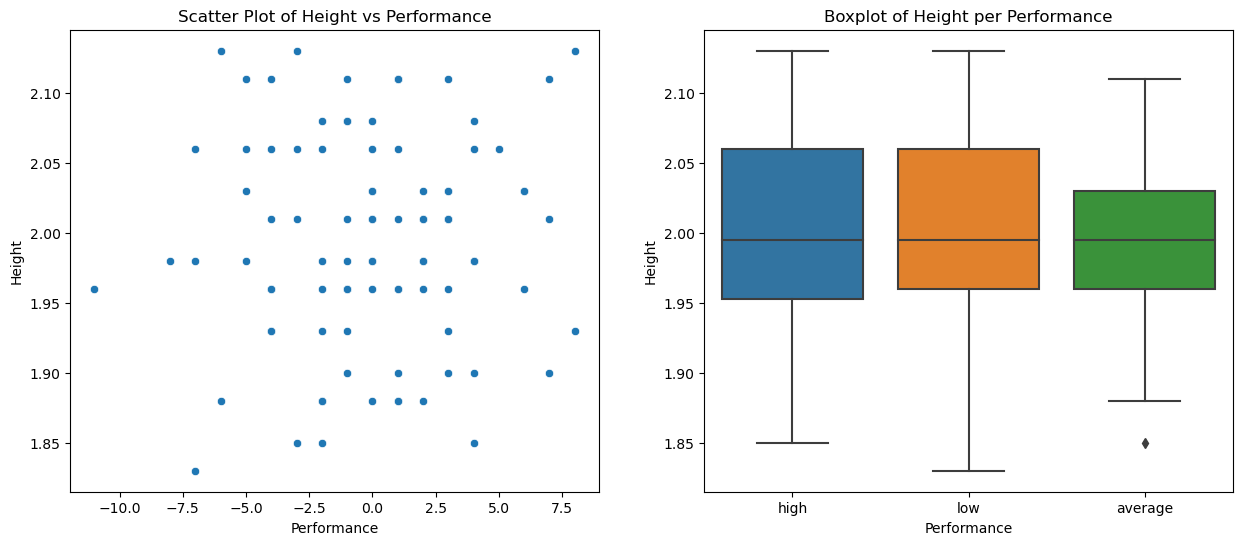

In [44]:
# Heigth per Performance
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

# Scatter plot
sns.scatterplot(x='plusMinus', y='height_m', data=final_df, ax=ax1)
ax1.set_xlabel('Performance')
ax1.set_ylabel('Height')
ax1.set_title(f'Scatter Plot of Height vs Performance')

# Boxplot
sns.boxplot(data = final_df, x = 'performance', y='height_m',  dodge=True, ax=ax2)
ax2.set_xlabel('Performance')
ax2.set_ylabel('Height')
ax2.set_title('Boxplot of Height per Performance')

# Save the plot to the specified file path
plt.savefig('../my-blog/assets/images/height&performance.png')

# Show the plot
plt.show()

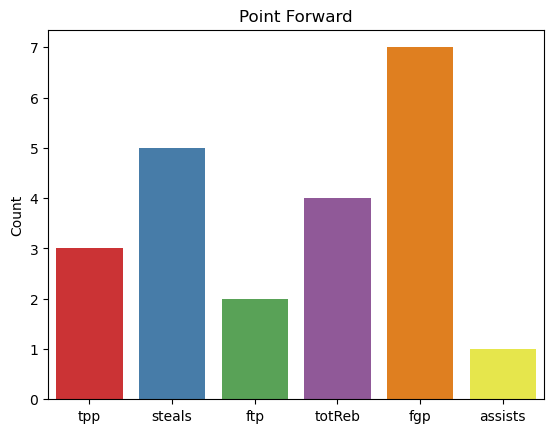

In [55]:
# Skill a Power Fordar must have

sns.countplot(x='b_strength', data=final_df[final_df['pos'] == 'PF'], palette='Set1')
plt.title('Point Forward')
plt.xlabel('')
plt.ylabel('Count')

# Save the plot to the specified file path
plt.savefig('../my-blog/assets/images/pf.png')

# Adjust layout to prevent clipping of titles
plt.show()

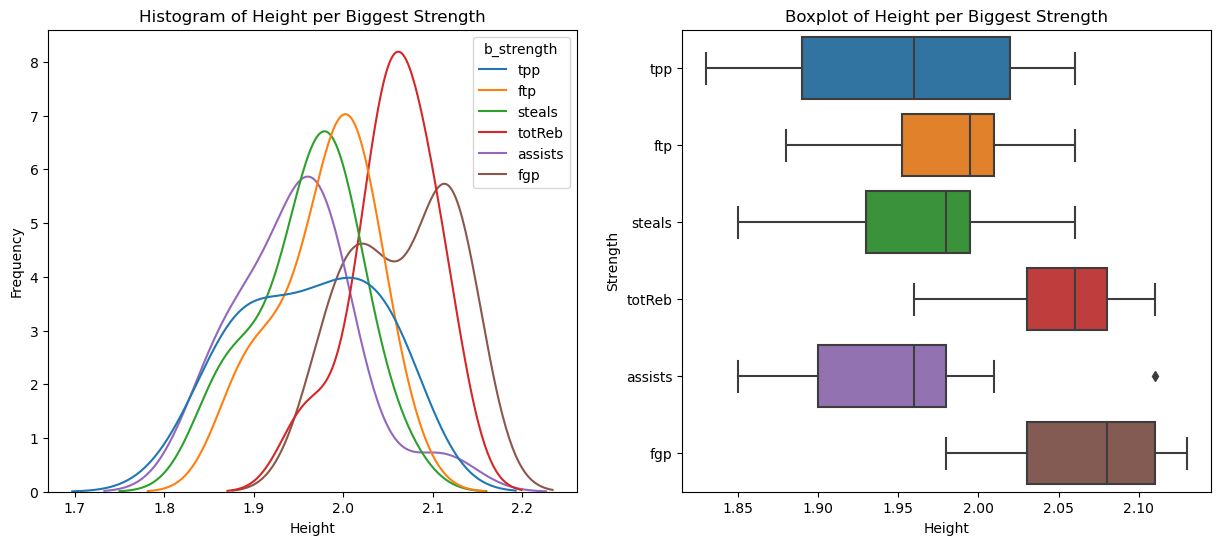

In [44]:
# Heigth per Biggest Strength

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

#Density curve
sns.kdeplot(data = final_df, x = 'height_m', hue='b_strength', ax=ax1, common_norm=False)
ax1.set_xlabel('Height')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Height per Biggest Strength')

# Box plot
sns.boxplot(data = final_df, x = 'height_m', y='b_strength',  dodge=True, ax=ax2)
ax2.set_xlabel('Height')
ax2.set_ylabel('Strength')
ax2.set_title('Boxplot of Height per Biggest Strength')

# Show the plot
plt.show()


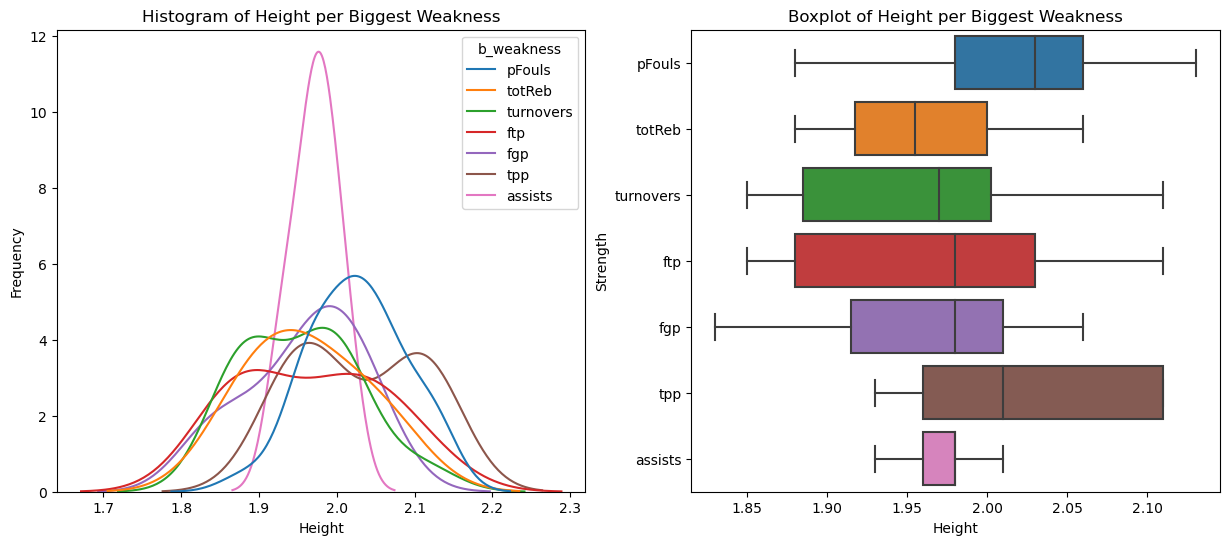

In [76]:
# Heigth per Biggest Weakness

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

#Density curve
sns.kdeplot(data = final_df, x = 'height_m', hue='b_weakness', ax=ax1, common_norm=False)
ax1.set_xlabel('Height')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Height per Biggest Weakness')

# Box plot
sns.boxplot(data = final_df, x = 'height_m', y='b_weakness',  dodge=True, ax=ax2)
ax2.set_xlabel('Height')
ax2.set_ylabel('Strength')
ax2.set_title('Boxplot of Height per Biggest Weakness')

# Show the plot
plt.show()

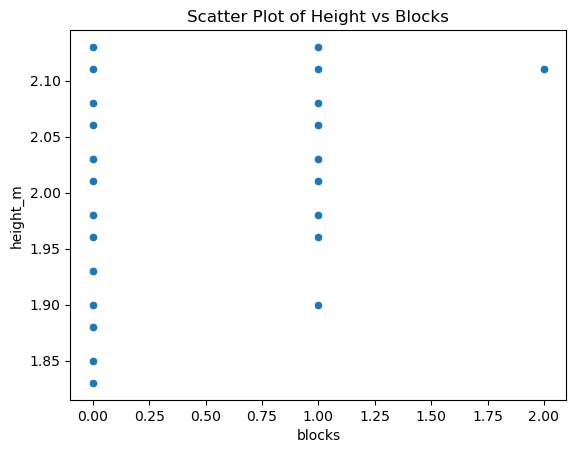

In [80]:
# Relationship between Heigth and Blocks
col1 = 'blocks'
col2 = 'height_m'

# Create a scatter plot
sns.scatterplot(x=col1, y=col2, data=final_df)

# Add labels and title
plt.xlabel(col1)
plt.ylabel(col2)
plt.title(f'Scatter Plot of Height vs Blocks')

# Show the plot
plt.show()

### SHOULD I MAKE BLOCKS A FACTOR?


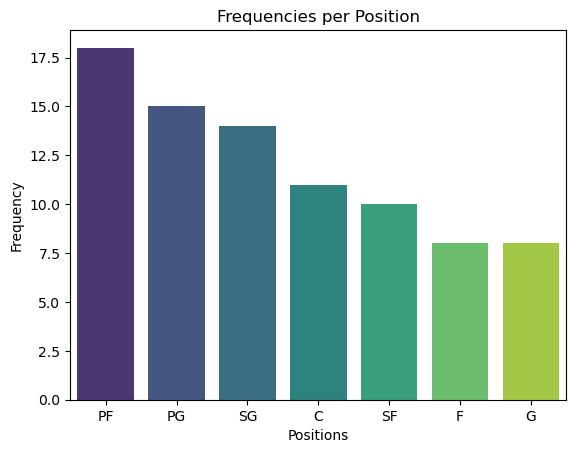

In [92]:
# Count of Positions
pos_counts = final_df['pos'].value_counts()

sns.barplot(x=pos_counts.index, y=pos_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('Positions')
plt.ylabel('Frequency')
plt.title('Frequencies per')

# Show the plot
plt.show()


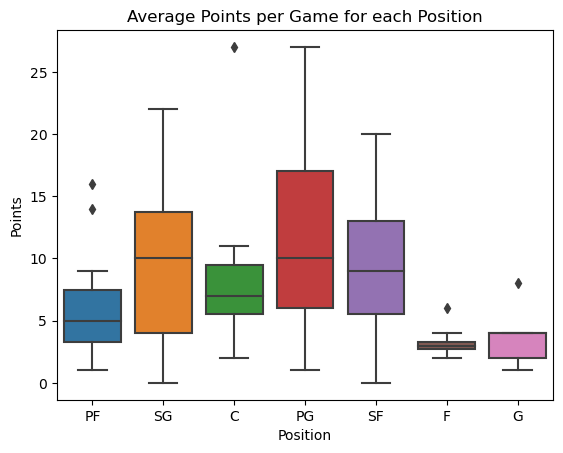

In [95]:
# Points per Position

sns.boxplot(data = final_df, x = 'pos', y='points',  dodge=True)
plt.xlabel('Position')
plt.ylabel('Points')
plt.title('Average Points per Game for each Position')

# Show the plot
plt.show()

In [107]:
# Positions Dictionary
p_n = {
    'PF': 'Power Forward',
    'SG': 'Shooting Guard',
    'C': 'Center',
    'PG': 'Point Guard',
    'SF': 'Small Forward',
    'F': 'Forward',
    'G': 'Guard'
}

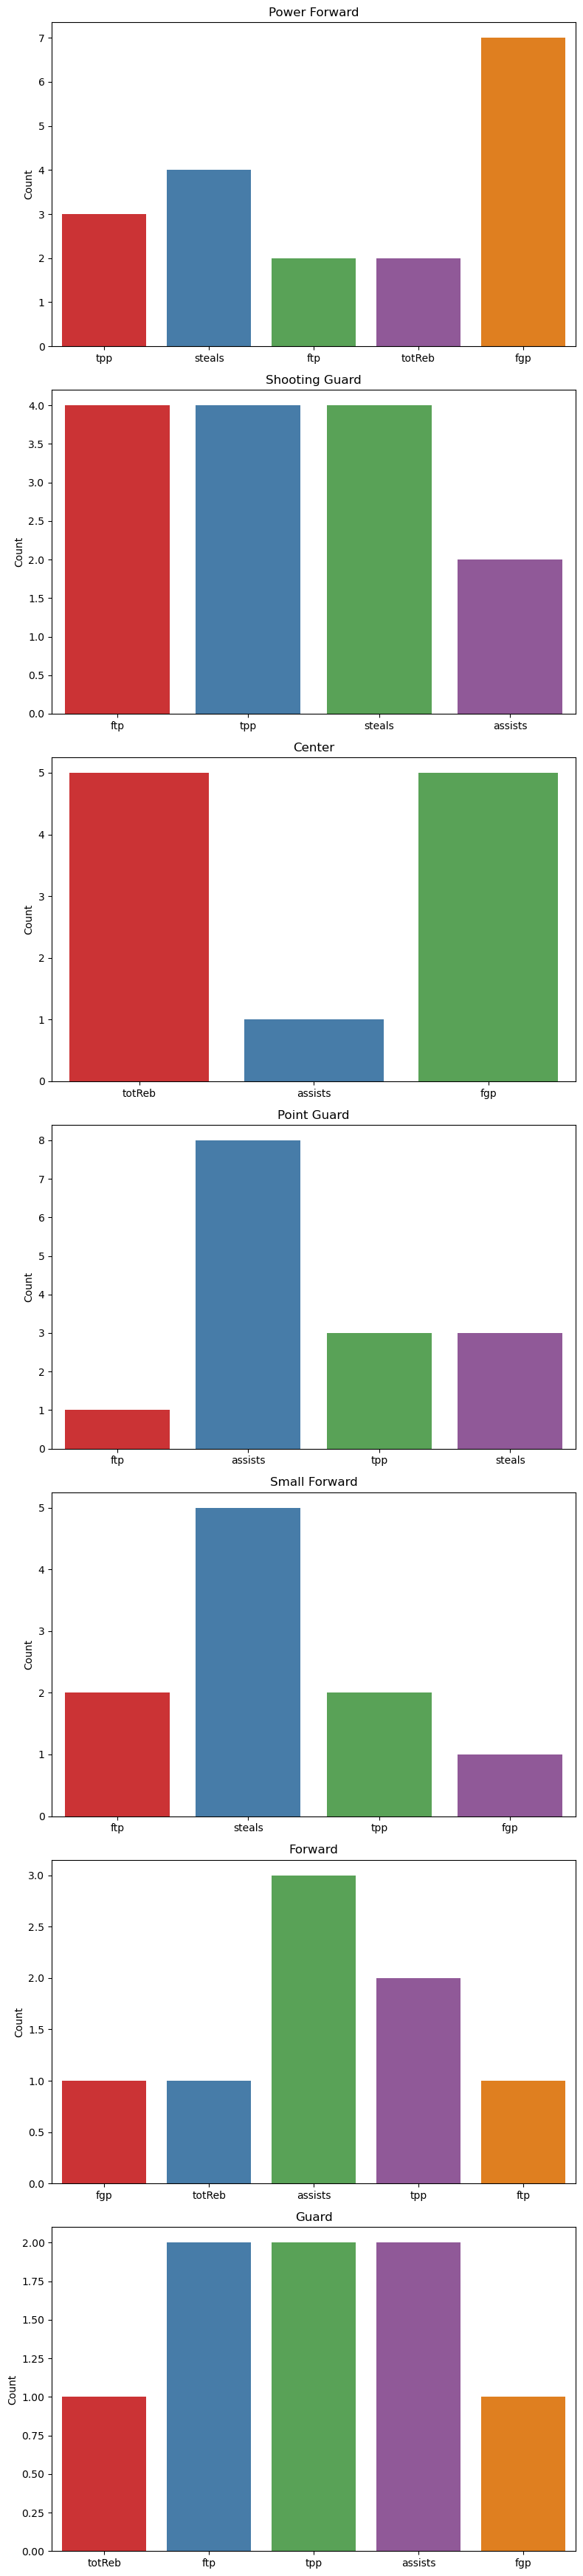

In [116]:
# Relationship between position and biggest strengths

# Get unique positions
unique_positions = final_df['pos'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=len(unique_positions), ncols=1, figsize=(8, 5 * len(unique_positions)))
fig.subplots_adjust(hspace=0.5)

# Plotting countplots for each unique position and b_strength combination in separate subplots
for pos, ax in zip(unique_positions, axes):
    sns.countplot(x='b_strength', data=final_df[final_df['pos'] == pos], palette='Set1', ax=ax)
    ax.set_title(f'{p_n[pos]}') ### 
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()


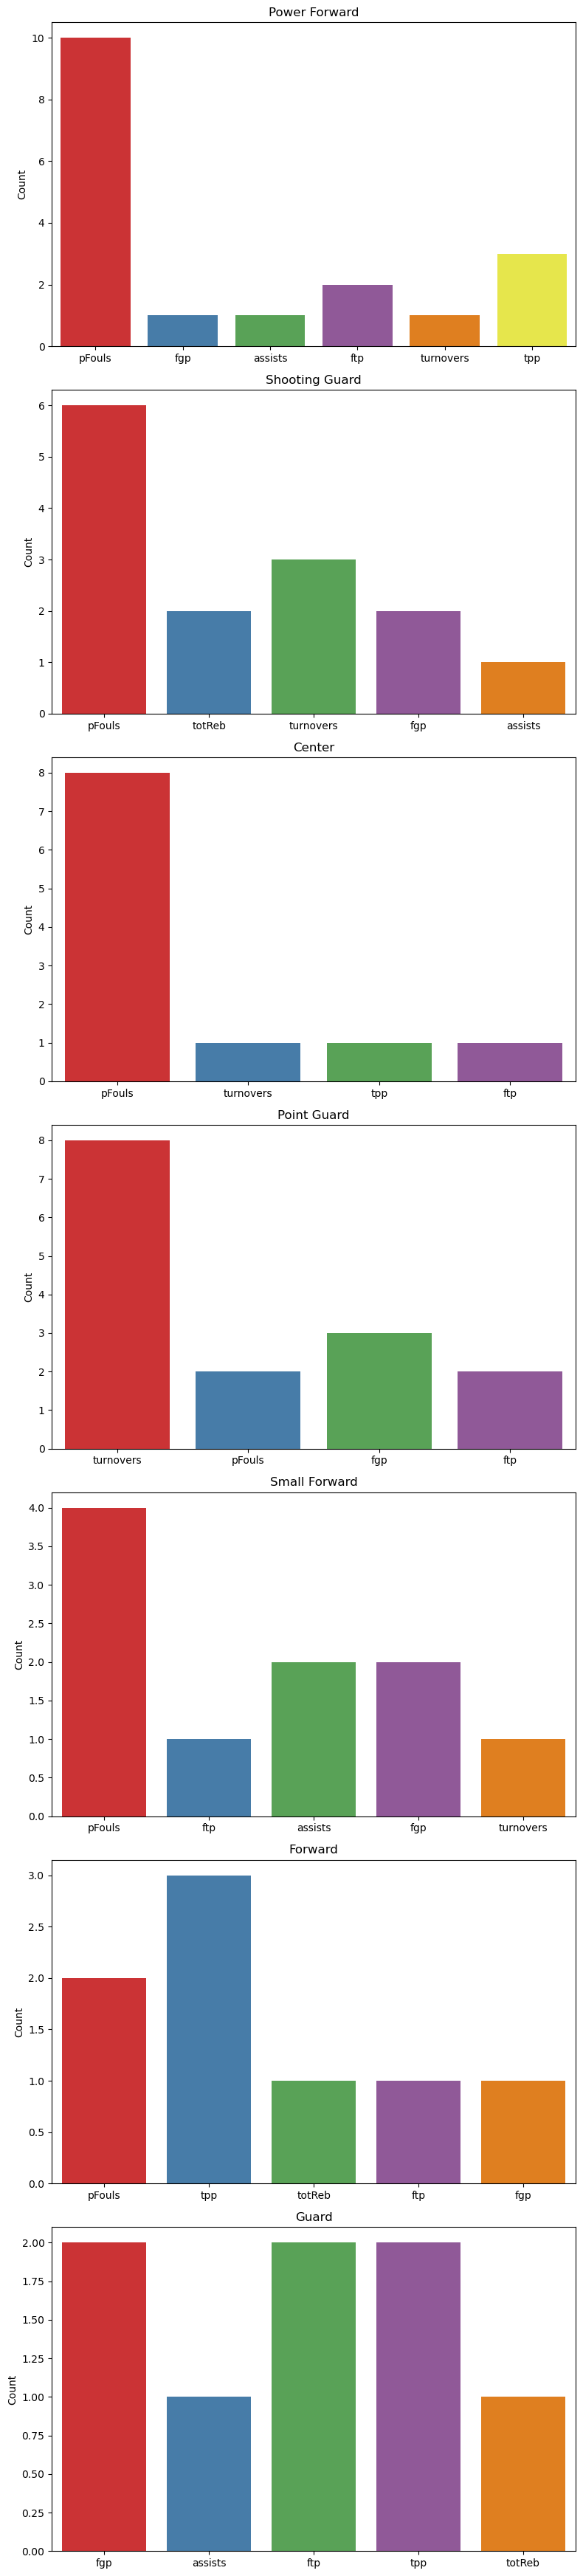

In [119]:
# Relationship between position and biggest weakness

# Get unique positions
unique_positions = final_df['pos'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=len(unique_positions), ncols=1, figsize=(8, 5 * len(unique_positions)))
fig.subplots_adjust(hspace=0.5)

# Plotting countplots for each unique position and b_strength combination in separate subplots
for pos, ax in zip(unique_positions, axes):
    sns.countplot(x='b_weakness', data=final_df[final_df['pos'] == pos], palette='Set1', ax=ax)
    ax.set_title(f'{p_n[pos]}') ### 
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

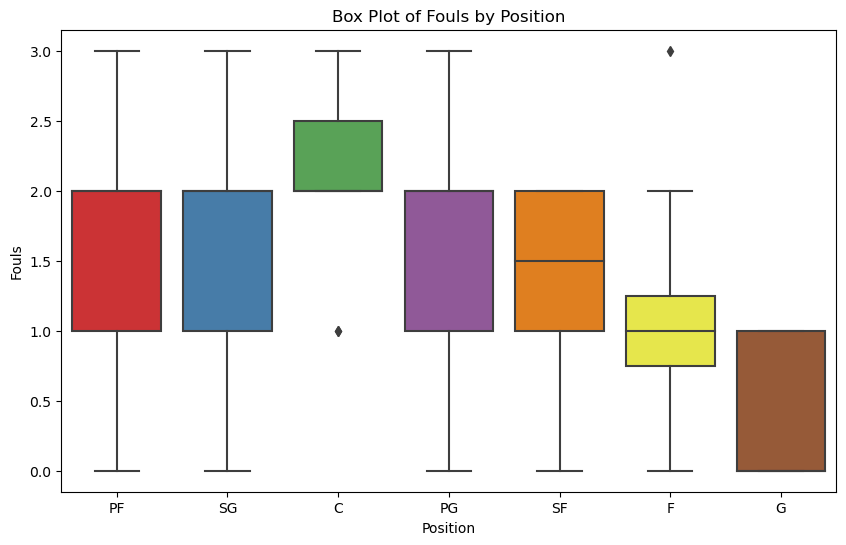

In [122]:
# Relationship between positions and fouls

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='pos', y='pFouls', data=final_df, palette='Set1')

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Fouls')
plt.title('Box Plot of Fouls by Position')

# Show the plot
plt.show()

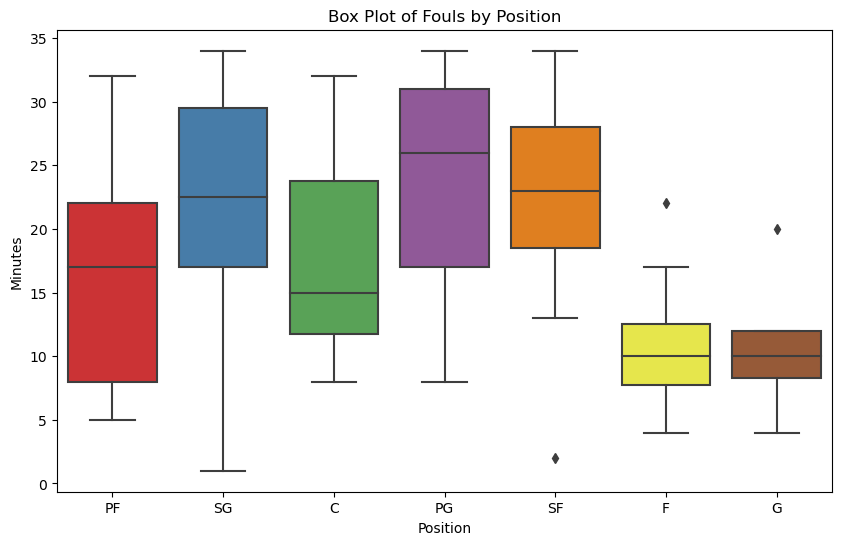

In [56]:
# Relationship between minutes in the court and posotion

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='pos', y='min', data=final_df, palette='Set1')

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Minutes')
plt.title('Box Plot of Fouls by Position')

# Show the plot
plt.show()


### Prepare Dashboard ###